In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copyright (C) 2018 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
from __future__ import print_function
import sys
sys.path.append('.')
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import scipy.stats as stats

from utils import get_config
from trainer import DGNet_Trainer, to_gray
import argparse
from torch.autograd import Variable
import sys
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
from torchvision.utils import save_image
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

This is not an error. If you want to use low precision, i.e., fp16, please install the apex with cuda support (https://github.com/NVIDIA/apex) and update pytorch to 1.0


In [8]:
name = '1_Structure_as_id_triplet'
# name = 'E0.5new_reid0.5_w30000_scratch_rgb_ir'

# if not os.path.isdir('./outputs/%s'%name):
#     assert 0, "please change the name to your model name"

parser = argparse.ArgumentParser()
parser.add_argument('--output_folder', type=str, default="./", help="output image path")
parser.add_argument('--input_folder', type=str, default="./visual_data/train_sysu", help="input image path")

parser.add_argument('--config', type=str, default='./outputs/%s/config.yaml'%name, help="net configuration")
parser.add_argument('--checkpoint_gen', type=str, default="./outputs/%s/checkpoints/gen_00100000.pt"%name, help="checkpoint of autoencoders")
parser.add_argument('--checkpoint_id', type=str, default="./outputs/%s/checkpoints/id_00100000.pt"%name, help="checkpoint of autoencoders")
parser.add_argument('--batchsize', default=4, type=int, help='batchsize')
parser.add_argument('--a2b', type=int, default=1, help="1 for a2b and others for b2a")
parser.add_argument('--seed', type=int, default=10, help="random seed")
parser.add_argument('--synchronized', action='store_true', help="whether use synchronized style code or not")
parser.add_argument('--output_only', action='store_true', help="whether use synchronized style code or not")
parser.add_argument('--trainer', type=str, default='DGNet', help="DGNet")


opts = parser.parse_args(args=[])

torch.manual_seed(opts.seed)
torch.cuda.manual_seed(opts.seed)
if not os.path.exists(opts.output_folder):
    os.makedirs(opts.output_folder)

teacher hyperparameter =  None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([7, 3, 256, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 2160x720 with 0 Axes>

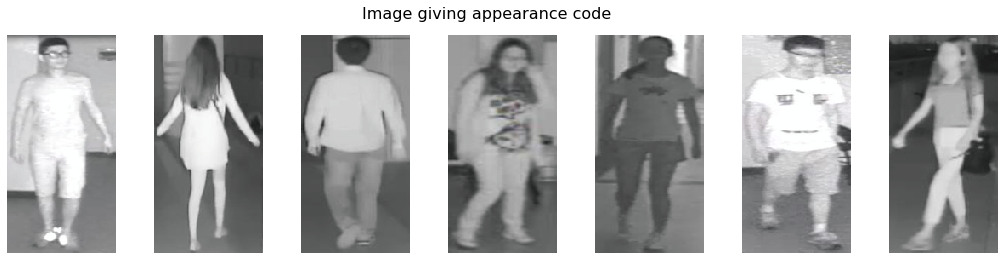

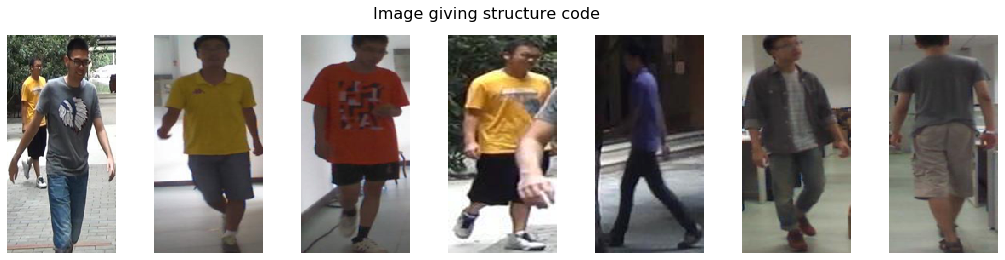

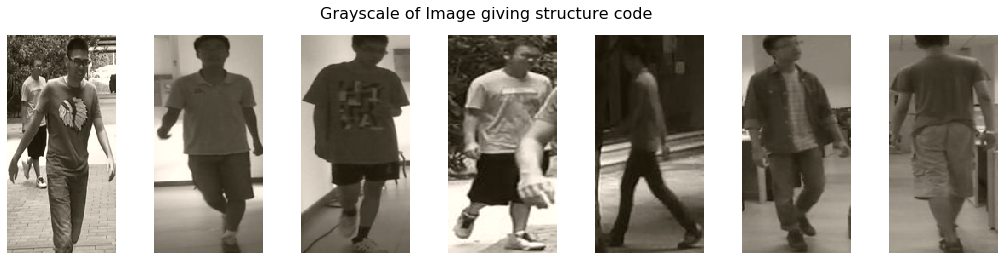

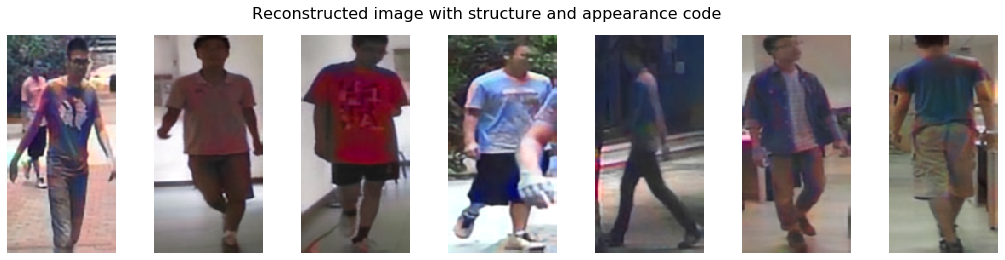

In [10]:
# Load experiment setting
# opts.config = './outputs/1_Structure_as_id/config.yaml'
config = get_config(opts.config)
num_style = 1
    
opts.checkpoint_gen = 'outputs/'+name+'/checkpoints/gen_00122000.pt'
opts.checkpoint_id = 'outputs/'+name+'/checkpoints/id_00122000.pt'


# Setup model and data loader
if opts.trainer == 'DGNet':
    trainer = DGNet_Trainer(config)
else:
    sys.exit("Only support DGNet")

state_dict_gen = torch.load(opts.checkpoint_gen)
trainer.gen_a.load_state_dict(state_dict_gen['a'], strict=False)
trainer.gen_b = trainer.gen_a

state_dict_id = torch.load(opts.checkpoint_id)
trainer.id_a.load_state_dict(state_dict_id['a'], strict=False)
trainer.id_b = trainer.id_a


trainer.cuda()
trainer.eval()
encode = trainer.gen_a.encode # encode function
style_encode = trainer.gen_a.encode # encode function
id_encode = trainer.id_a # encode function
decode = trainer.gen_a.decode # decode function


data_transforms = transforms.Compose([
        transforms.Resize((256,128), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets1 = datasets.ImageFolder(opts.input_folder+'/report_ir', data_transforms)
image_datasets2 = datasets.ImageFolder(opts.input_folder+'/report_rgb', data_transforms)
num = 7
dataloader_content = torch.utils.data.DataLoader(image_datasets1, batch_size=num, shuffle=False, num_workers=1)
dataloader_structure = torch.utils.data.DataLoader(image_datasets2, batch_size=num, shuffle=False, num_workers=1)

count = 0
count_ = 0
gray = to_gray(False)
fig = plt.figure(figsize=(30,10))

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
    normalize
])

def recover(inp):
    """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
#     inp = inp * 255.0
    inp = np.clip(inp, 0, 255)
    return inp

def generate(data1, data2):  
    bg_img, _ = data1
    bg_img = Variable(bg_img.cuda())
    id_img, _ = data2
    print(id_img.shape)
    id_img = Variable(gray(id_img).cuda())
    s, _ = encode(id_img) # s shape = (128x64x32) #ir
    f = id_encode(bg_img) # f shape = (bsx8192) #rgb
    output = decode(s, f)
    return s, output


def getStructure(data):
    data, _ = data
    data = gray(data)
    s,p = encode(data.cuda())
    return s 

with torch.no_grad():
    
 ########## FOR PLOTTING SAME ID INPUT AND OUTPUT ############
    fig = plt.figure(figsize=(18,4))
    fig.suptitle("Image giving appearance code", fontsize=16)
    for rgb_a, rgb_p in zip(dataloader_content, dataloader_structure): 
        _, output = generate(rgb_a, rgb_p)
        rgb_a = np.transpose(rgb_a[0].cpu(),(0,2,3,1))
        rgb_a = np.stack([recover(x_) for x_ in rgb_a.cpu().numpy()])
        
        rgb_color = rgb_p[0]
        rgb_color = np.transpose(rgb_color.cpu(),(0,2,3,1))
        rgb_color = np.stack([recover(x_) for x_ in rgb_color.cpu().numpy()])
        
        rgb_p = gray(rgb_p[0])
        rgb_p = np.transpose(rgb_p.cpu(),(0,2,3,1))
        rgb_p = np.stack([recover(x_) for x_ in rgb_p.cpu().numpy()])
        
        output = np.transpose(output.cpu(),(0,2,3,1))
        output = np.stack([recover(x_) for x_ in output.cpu().numpy()])
        break
    filter_num = 0
    count = 1
    for i in range (num):
        plt.subplot(1,num,count)
        plt.imshow(rgb_a[i,:,:,:],cmap='gray')
        count += 1
        plt.axis('off')
        
    count = 1
    fig = plt.figure(figsize=(18,4))
    fig.suptitle("Image giving structure code", fontsize=16)
    for i in range (num):
        plt.subplot(1,num,count)
        plt.imshow(rgb_color[i,:,:,:],cmap='gray')
        count += 1
        plt.axis('off')
        
    count = 1
    fig = plt.figure(figsize=(18,4))
    fig.suptitle("Grayscale of Image giving structure code", fontsize=16)
    for i in range (num):
        plt.subplot(1,num,count)
        plt.imshow(rgb_p[i,:,:,:],cmap='gray')
        count += 1
        plt.axis('off')
    
    count = 1
    fig = plt.figure(figsize=(18,4))
    fig.suptitle("Reconstructed image with structure and appearance code", fontsize=16)
    for i in range (num):
        plt.subplot(1,num,count)#WHY
        plt.imshow(output[i,:,:,:],cmap='gray')
        count += 1
        plt.axis('off')

    plt.show()
    
    ########## FOR PLOTTING STRUCTURE ENCODER FEATURE MAPS FOR SWAP DATA ############
#     fig = plt.figure(figsize=(28,8))
#     for rgb, ir in zip(dataloader_content, dataloader_structure): 
#         s, output = generate(rgb, ir)
#         s = s.cpu()
#         output = np.transpose(output.cpu(),(0,2,3,1))
#         output = np.stack([recover(x_) for x_ in output.cpu().numpy()])
        
#         break
#     filter_num = 0
#     count = 1
#     for i in range (4):
#         plt.subplot(2,4,count)
#         plt.imshow(s[i,filter_num,:,:],cmap='gray')
#         count += 1
#     fig = plt.figure(figsize=(28,8))
#     for i in range (4):
#         plt.subplot(2,4,count)#WHY
#         plt.imshow(output[i,:,:,:],cmap='gray')
#         count += 1
#     plt.show()

    ########## FOR PLOTTING STRUCTURE ENCODER FEATURE MAPS ############
#     fig = plt.figure(figsize=(28,8))
#     for rgb, ir in zip(dataloader_content, dataloader_structure): 
#         s_rgb = (getStructure(rgb).cpu())
#         s_ir = (getStructure(ir).cpu())
#         break
#     print(s_rgb.shape)
#     filter_num = 3
#     count = 1
#     for i in range (10):
#         plt.subplot(2,10,count)
#         count += 1
#         plt.imshow(s_rgb[filter_num,i,:,:], cmap='gray')

#     for i in range (10):
#         plt.subplot(2,10,count)
#         count += 1
#         plt.imshow(s_ir[filter_num,i,:,:], cmap='gray')

#     plt.show()
#     ########## FOR PLOTTING STRUCTURE ENCODER FEATURE MAPS ############